In [9]:
import sys, os
sys.path.append(os.path.abspath('..'))

from dataset import RibFracDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

context_size = 2

dataset = RibFracDataset(
    root_dir='../data',
    partition='val',
    context_size=context_size,
    patch_original_size=64,
    patch_final_size=64,
    proportion_fracture_in_patch=0.05,
    clip_min_val=100,
    clip_max_val=8000,
    test_stride=64,
    debug=True
)
sampler = dataset.get_test_sampler()

batch_size = 4
dataloader = DataLoader(
    dataset=dataset,
    sampler=sampler,
    batch_size=batch_size,
)
iter_dataloader = iter(dataloader)

num_p = int(dataset.num_patches)
num_p_sqrt = int(np.sqrt(num_p))

Creating local prediction masks: 100%|██████████| 80/80 [00:00<00:00, 38555.02it/s]


# Extract patches for first image

In [10]:
patches = []
coords = []
for i in range(int(np.ceil(num_p/batch_size))):
    img_patches, c, f, s, pts, img = next(iter_dataloader)
    patches.append(img_patches)
    coords.append(np.array(c).T)
patches = torch.cat(patches, dim=0)
coords = np.concatenate(coords, axis=0)
patches = patches[:num_p]
coords = coords[:num_p]

patches = patches[:, context_size, :, :]
patch_original_size = pts[0].item()

# Build reconstructed input

In [11]:
side = img.shape[2]
recon = torch.zeros((side, side))
recon_sum = torch.zeros((side, side))
resize = transforms.Resize(patch_original_size, antialias=True)
p = patch_original_size // 2

for i, (patch,c) in enumerate(zip(patches, coords)):
    patch = resize(patch.unsqueeze(0)).squeeze(0)
    ix, iy = c
    recon[
        ix - p : ix + p,
        iy - p : iy + p,
    ] += patch
    recon_sum[
        ix - p : ix + p,
        iy - p : iy + p,
    ] += 1
recon /= recon_sum
recon = recon[p:-p, p:-p]

img = img[0, context_size, :, :].numpy()[p:-p, p:-p]

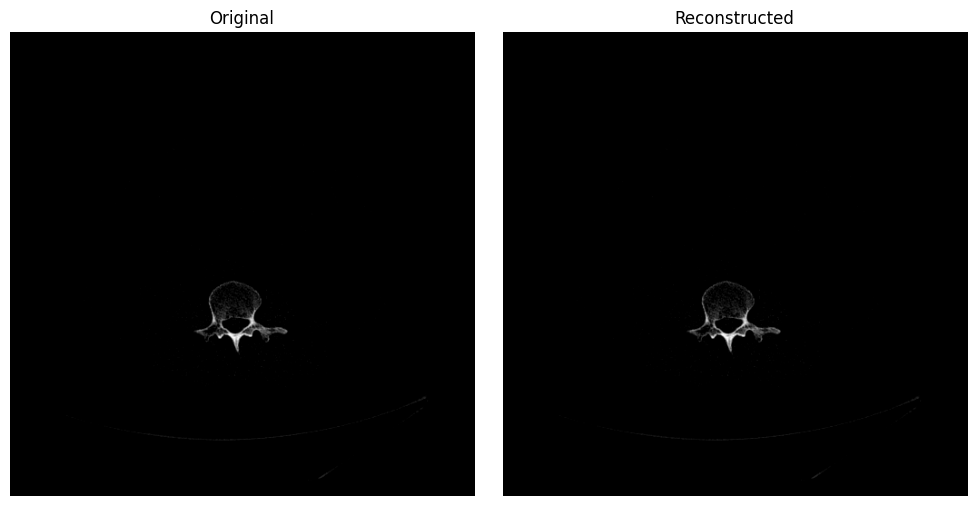

In [12]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[1].imshow(recon, cmap='gray')
axes[0].set_title('Original')
axes[1].set_title('Reconstructed')
axes[0].axis('off')
axes[1].axis('off') 
plt.tight_layout()
plt.show()